In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
plt.style.use('ggplot')

Data Source: /kaggle/input/amazon-fine-food-reviews/Reviews.csv

In [77]:
raw_df = pd.read_csv('./Reviews.csv')
print(raw_df.shape)

(568454, 10)


In [78]:
df = raw_df.tail(1000).copy()

In [79]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
567454,567455,B006UX8M2Y,A1PHY7KZK1DT6J,Jackie D. Buffat,0,0,5,1337472000,Jelly Belly Buttered Popcorn Jelly Beans,These are the BEST!!! If you like popcorn and ...
567455,567456,B006UX8M2Y,A1H7Z0F4W0ARME,Moody,4,8,1,1299888000,Never arrived!,"This package never arrived, even though it's m..."
567456,567457,B000NA8OM8,ADFPIHVFFGEA0,Cookie Lover,0,0,5,1202256000,Super tasting soft cookies,The more you buy the more you save in postage....
567457,567458,B001HTIRTY,A3410OMLBNV6E0,Amy,1,1,5,1302393600,Very good red curry sauce!,I really like the Rogan Josh sauce. It's a gre...
567458,567459,B001HTIRTY,A1IG0VSNG02HAN,"Oxwilder ""oxwilder""",0,0,2,1342396800,"Buy at the store, if at all.","I thought that in the age of online shopping, ..."


## EDA

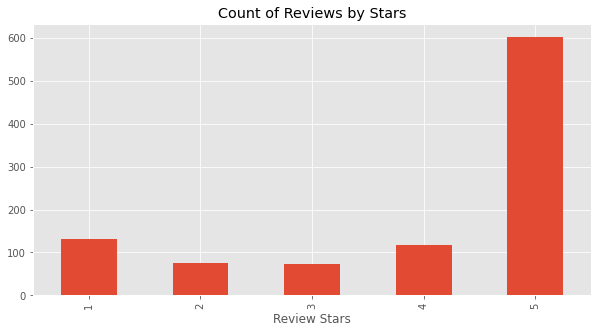

In [80]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## NLTK

In [81]:
e = df['Text'].iloc[98]
print(e)

This is a great product.  My very picky cats love it.  This is the first food they eat every bite of.  Well worth the price because none of it is wasted.


In [82]:
tokens = nltk.word_tokenize(e)
tokens[:20]

['This',
 'is',
 'a',
 'great',
 'product',
 '.',
 'My',
 'very',
 'picky',
 'cats',
 'love',
 'it',
 '.',
 'This',
 'is',
 'the',
 'first',
 'food',
 'they',
 'eat']

In [83]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('great', 'JJ'),
 ('product', 'NN'),
 ('.', '.'),
 ('My', 'PRP$'),
 ('very', 'RB'),
 ('picky', 'JJ'),
 ('cats', 'NNS')]

In [84]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  is/VBZ
  a/DT
  great/JJ
  product/NN
  ./.
  My/PRP$
  very/RB
  picky/JJ
  cats/NNS
  love/VBP
  it/PRP
  ./.
  This/DT
  is/VBZ
  the/DT
  first/JJ
  food/NN
  they/PRP
  eat/VBP
  every/DT
  bite/NN
  of/IN
  ./.
  Well/NNP
  worth/IN
  the/DT
  price/NN
  because/IN
  none/NN
  of/IN
  it/PRP
  is/VBZ
  wasted/VBN
  ./.)


# VADER

NLTK module that provides sentiment scores based on the words used. It is a rule-based sentiment analyzer in which the terms are generally labeled as per their semantic orientation as either positive or negative.

In [85]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [86]:
print(sia.polarity_scores('Seems good upto this point.'))
print(sia.polarity_scores('NLP seems interesting!'))
print(sia.polarity_scores(e))

{'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compound': 0.4404}
{'neg': 0.0, 'neu': 0.401, 'pos': 0.599, 'compound': 0.4574}
{'neg': 0.079, 'neu': 0.613, 'pos': 0.308, 'compound': 0.8542}


In [87]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [88]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,567455,0.000,0.583,0.417,0.9652,B006UX8M2Y,A1PHY7KZK1DT6J,Jackie D. Buffat,0,0,5,1337472000,Jelly Belly Buttered Popcorn Jelly Beans,These are the BEST!!! If you like popcorn and ...
1,567456,0.152,0.804,0.044,-0.8104,B006UX8M2Y,A1H7Z0F4W0ARME,Moody,4,8,1,1299888000,Never arrived!,"This package never arrived, even though it's m..."
2,567457,0.000,0.772,0.228,0.9466,B000NA8OM8,ADFPIHVFFGEA0,Cookie Lover,0,0,5,1202256000,Super tasting soft cookies,The more you buy the more you save in postage....
3,567458,0.000,0.799,0.201,0.9642,B001HTIRTY,A3410OMLBNV6E0,Amy,1,1,5,1302393600,Very good red curry sauce!,I really like the Rogan Josh sauce. It's a gre...
4,567459,0.072,0.878,0.050,-0.5050,B001HTIRTY,A1IG0VSNG02HAN,"Oxwilder ""oxwilder""",0,0,2,1342396800,"Buy at the store, if at all.","I thought that in the age of online shopping, ..."


## VADER Plots

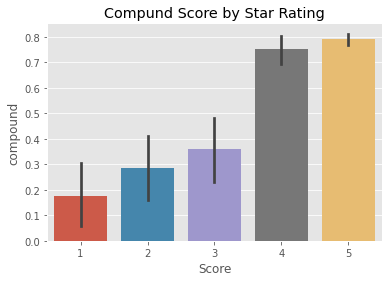

In [89]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Star Rating')
plt.show()

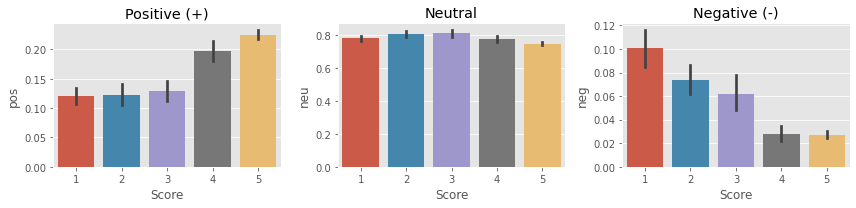

In [90]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive (+)')
axs[1].set_title('Neutral')
axs[2].set_title('Negative (-)')
plt.tight_layout()
plt.show()

# RoBERTa

- Trained of a large corpus of data.
- Transformer model accounts for contexual word embeddings.

In [91]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [92]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [93]:
print(f"VADER: \n\n {e}\n")
sia.polarity_scores(e)

VADER: 

 This is a great product.  My very picky cats love it.  This is the first food they eat every bite of.  Well worth the price because none of it is wasted.



{'neg': 0.079, 'neu': 0.613, 'pos': 0.308, 'compound': 0.8542}

In [94]:
encoded_text = tokenizer(e, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0025824339, 'roberta_neu': 0.010204494, 'roberta_pos': 0.98721313}


In [95]:
def polarity_scores_roberta(e):
    encoded_text = tokenizer(e, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [96]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id 567529
Broke for id 567533
Broke for id 567686
Broke for id 568091
Broke for id 568131
Broke for id 568158
Broke for id 568250


In [97]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

## VADER vs RoBERTa

In [98]:
results_df

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,567455,0.000,0.583,0.417,0.9652,0.001111,0.006620,0.992269,B006UX8M2Y,A1PHY7KZK1DT6J,Jackie D. Buffat,0,0,5,1337472000,Jelly Belly Buttered Popcorn Jelly Beans,These are the BEST!!! If you like popcorn and ...
1,567456,0.152,0.804,0.044,-0.8104,0.939807,0.053396,0.006796,B006UX8M2Y,A1H7Z0F4W0ARME,Moody,4,8,1,1299888000,Never arrived!,"This package never arrived, even though it's m..."
2,567457,0.000,0.772,0.228,0.9466,0.003798,0.030926,0.965276,B000NA8OM8,ADFPIHVFFGEA0,Cookie Lover,0,0,5,1202256000,Super tasting soft cookies,The more you buy the more you save in postage....
3,567458,0.000,0.799,0.201,0.9642,0.001476,0.019443,0.979081,B001HTIRTY,A3410OMLBNV6E0,Amy,1,1,5,1302393600,Very good red curry sauce!,I really like the Rogan Josh sauce. It's a gre...
4,567459,0.072,0.878,0.050,-0.5050,0.716865,0.250379,0.032756,B001HTIRTY,A1IG0VSNG02HAN,"Oxwilder ""oxwilder""",0,0,2,1342396800,"Buy at the store, if at all.","I thought that in the age of online shopping, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,568450,0.072,0.600,0.327,0.8589,0.003201,0.014728,0.982071,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
989,568451,0.190,0.697,0.114,-0.4848,0.940428,0.052000,0.007572,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
990,568452,0.037,0.884,0.078,0.4352,0.309629,0.474690,0.215681,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
991,568453,0.041,0.506,0.452,0.9717,0.001290,0.012503,0.986207,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


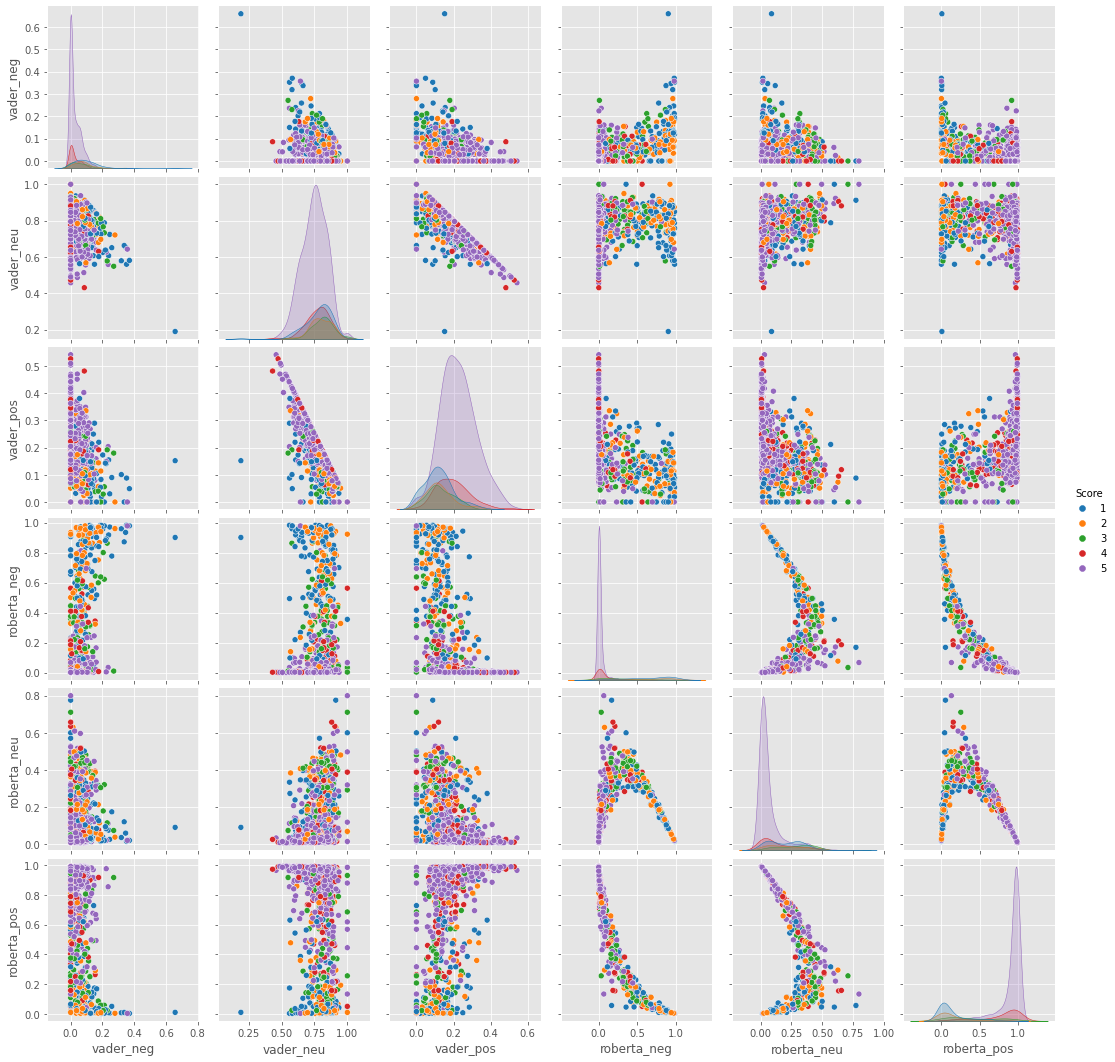

In [99]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Positive 1-Star and Negative 5-Star Reviews

In [100]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

"I was so hoping she would like this because it is so healthy and would be easy to take camping and out to dinner...but she wouldn't eat any of it and kept spitting it out. I gave it to the dogs and they loved it and I am sure it is healthy for them!"

In [101]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

"I used to use 3 sweet and low's...this one takes 6 packes! and even then it's not sweet but bitter! yak  Truvia is a lot better! I use 3 truvias..and that one is sweet and has no aftertaste like this stuff"

In [102]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'Ordered coffee for a few months. Now I would not recommend it to my worst enemy. The coffee now has no aroma, is light brown and taste worse than ___________.  (fill in the blank)'

In [103]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[1]

"Sleepy time tea is the perfect remedy for sleeplessness, anxiety, restlessness, and Restless leg syndrome when one doesn't want to take harsh medicines that could mess with their symptoms.<br /><br />I suffer from RLS and insomnia and this tea helps me relax, unwind, de-stress, and drift into a nice REM sleep when I need to.<br /><br />AND IT IS DELICIOUS!"

# Transformers pipeline

In [104]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [105]:
print(sent_pipeline('Transformers are fun to work with!!!'))
print(sent_pipeline('booo'))

[{'label': 'POSITIVE', 'score': 0.9997764229774475}]
[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]
